In [1]:
# importovanje biblioteka koje ce nam biti potrebne kasnije
import numpy as np
import pandas as pd 
import time
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
import shap

In [2]:
X_sm=pd.read_csv('D:\\Vlada\\Milica master\\X_sm_2.csv')
y_sm=pd.read_csv('D:\\Vlada\\Milica master\\y_sm_2.csv')
X_test=pd.read_csv('D:\\Vlada\\Milica master\\X_test_2.csv')
y_test=pd.read_csv('D:\\Vlada\\Milica master\\y_test_2.csv')

In [3]:
X_test.shape

(200, 10)

In [4]:
X_test.head()

,ID,Age,Credit amount,Duration,Sex,Job,Housing,Saving accounts,Checking account,Purpose
0,30,0.061263,-0.477788,-0.234548,male,2,own,rich,moderate,business
1,128,-0.119922,-0.497625,-0.742595,male,3,own,little,moderate,car
2,289,1.148377,-0.810513,0.273499,male,2,own,little,little,radio/TV
3,216,-0.391701,-0.032034,-0.234548,male,2,own,little,little,business
4,966,-1.116443,-0.250607,0.527522,male,1,own,quite rich,moderate,radio/TV


In [5]:
X_sm=X_sm.drop(columns='ID')
X_test=X_test.drop(columns='ID')

In [6]:
# kreiramo dummy varijable
X_sm = pd.get_dummies(X_sm)
X_test = pd.get_dummies(X_test)
X_sm, X_test = X_sm.align(X_test, join='left', axis=1)

## Logisticka regresija

In [7]:
#trazimo najbolji regularizacioni parametar 
grid_model = LogisticRegression()
params = {'C': [10**i for i in range(-5, 5)]}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='roc_auc', cv=5, return_train_score=True)

In [8]:
grid.fit(X_sm, y_sm)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             return_train_score=True, scoring='roc_auc')

In [9]:
grid.best_params_

{'C': 1}

In [10]:
log_reg = LogisticRegression(C = 1)

# Treniramo model na trening setu
log_reg.fit(X_sm, y_sm)

LogisticRegression(C=1)

In [11]:
log_reg_pred = log_reg.predict_proba(X_test)
log_reg_pred

array([[0.83418988, 0.16581012],
       [0.3721012 , 0.6278988 ],
       [0.36946245, 0.63053755],
       [0.37978437, 0.62021563],
       [0.65012863, 0.34987137],
       [0.53492712, 0.46507288],
       [0.30611151, 0.69388849],
       [0.59743724, 0.40256276],
       [0.26848143, 0.73151857],
       [0.78019596, 0.21980404],
       [0.86271391, 0.13728609],
       [0.2877962 , 0.7122038 ],
       [0.90885549, 0.09114451],
       [0.50312872, 0.49687128],
       [0.22869345, 0.77130655],
       [0.88870003, 0.11129997],
       [0.45011075, 0.54988925],
       [0.91239555, 0.08760445],
       [0.72123822, 0.27876178],
       [0.97285749, 0.02714251],
       [0.88547164, 0.11452836],
       [0.66464512, 0.33535488],
       [0.83551068, 0.16448932],
       [0.18675184, 0.81324816],
       [0.38454491, 0.61545509],
       [0.32049048, 0.67950952],
       [0.97320434, 0.02679566],
       [0.78530561, 0.21469439],
       [0.82914585, 0.17085415],
       [0.80210706, 0.19789294],
       [0.

In [12]:
predicted = log_reg.predict(X_sm)
report = classification_report(y_sm, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       560
           1       0.73      0.80      0.77       560

    accuracy                           0.76      1120
   macro avg       0.76      0.76      0.76      1120
weighted avg       0.76      0.76      0.76      1120



In [13]:
predicted = log_reg.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.71      0.78       140
           1       0.51      0.70      0.59        60

    accuracy                           0.71       200
   macro avg       0.68      0.71      0.68       200
weighted avg       0.75      0.71      0.72       200



In [14]:
confusion_matrix(y_test, predicted)

array([[100,  40],
       [ 18,  42]], dtype=int64)

In [15]:
valid_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])

In [16]:
valid_auc

0.7673809523809524

## Slucajna suma

In [138]:
params = {'n_estimators': [100, 500, 1000], 
              'max_features': ['log2', 'sqrt'],
              'max_depth': [3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
              'min_samples_split': [2, 6, 10], 
              'min_samples_leaf': [1, 3, 4], 
              'max_samples':[0.6,0.8,1.0],
              'bootstrap': [True, False]} 

In [139]:
random_forest = RandomizedSearchCV(estimator = RandomForestClassifier(),param_distributions = params,
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [140]:
random_forest.fit(X_sm, y_sm)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   53.9s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 10, 20, 30, 40,
                                                      50, 60, 70, 80, 90, 100,
                                                      110, 120],
                                        'max_features': ['log2', 'sqrt'],
                                        'max_samples': [0.6, 0.8, 1.0],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [100, 500, 1000]},
                   random_state=42, verbose=2)

In [141]:
print ('Best Parameters: ', random_forest.best_params_, ' \n')

Best Parameters:  {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 80, 'bootstrap': True}  



In [142]:
print ('Best Parameters: ', random_forest.best_estimator_, ' \n')

Best Parameters:  RandomForestClassifier(max_depth=80, max_features='log2', max_samples=0.8,
                       min_samples_split=10, n_estimators=500)  



In [143]:
random_forest = RandomForestClassifier(max_depth=80, min_samples_split=10, min_samples_leaf=1, max_samples=0.8, max_features='log2',bootstrap=True,n_estimators=500, random_state = 42, verbose = 1, n_jobs = -1)

In [132]:
#algoritam slucajne sume, parametri 100 stabala, n_jobs=-1 znaci da koristi sve procesore
#random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42, verbose = 1, n_jobs = -1)

In [144]:
#treniramo model
random_forest.fit(X_sm, y_sm)
features = list(X_sm.columns)
#izvlacimo najbitnije varijable
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

#predikcija na test setu
predictions = random_forest.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


In [145]:
predicted_rf = random_forest.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


In [146]:
report_rf=classification_report(y_test,predicted_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       140
           1       0.57      0.65      0.60        60

    accuracy                           0.74       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.76      0.74      0.75       200



In [147]:
valid_auc_rf = roc_auc_score(y_test, predictions)

In [148]:
valid_auc_rf

0.7695238095238095

In [149]:
def plot_feature_importances(df):
    
    #sortiranje varijabli po znacaju
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalizujemo varijable da bi im suma bila 1
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    #bar chart
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    plt.xlabel('Normalizovan doprinos varijable'); plt.title('Znacajnost varijabli')
    plt.show()
    
    return df

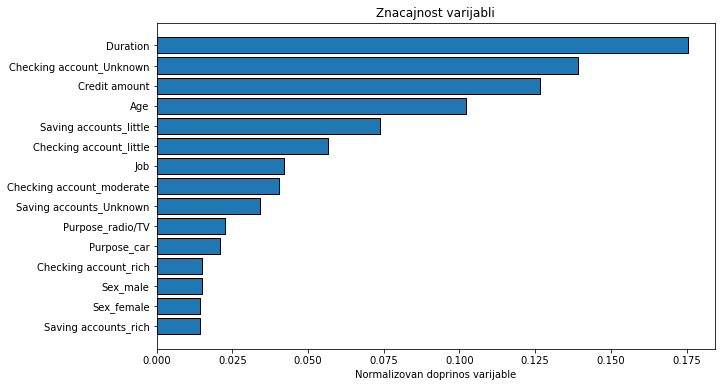

In [150]:
feature_importances_sorted = plot_feature_importances(feature_importances)

In [151]:
confusion_matrix(y_test, predicted_rf)

array([[110,  30],
       [ 21,  39]], dtype=int64)

## XGBoost

In [152]:
#Parametri za XGBoost
params = {
        'n_estimators' : [100,500,1000],
        'eta':[0.01, 0.05, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 2, 3, 5, 10, 20],
        'gamma': [0.1, 0.5, 1, 1.5, 2, 5, 3],
        'max_delta_step':[1, 3, 5, 10],
        'subsample': [ 0.6, 0.8, 1.0],
        'colsample_bytree': [ 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'eval_metric': ['auc'],
        'tree_method':['auto', 'exact']
        }

In [153]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Vreme utroseno %i sati %i minuta i %s sekundi.' % (thour, tmin, round(tsec, 2)))

In [168]:
folds = 5
param_comb = 500

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(estimator=XGBClassifier(objective='binary:logistic'), param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_sm,y_sm), verbose=3, random_state=1001 )

start_time = timer(None)
random_search.fit(X_sm, y_sm)
timer(start_time)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   36.5s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 2500 out of 2500 | elapsed:  6.6min finished



 Vreme utroseno 0 sati 6 minuta i 38.04 sekundi.


In [169]:
print('\n Rezultati:')
print(random_search.cv_results_)
print('\n Najbolji prediktor:')
print(random_search.best_estimator_)
print('\n Najbolji parametri:')
print(random_search.best_params_)


 Rezultati:
{'mean_fit_time': array([0.39873166, 0.91395464, 0.83995261, 0.31974411, 0.09614267,
       0.59181647, 0.34268293, 0.98566909, 0.98318868, 1.31438751,
       1.10464444, 0.11229954, 0.62552609, 0.09534469, 0.15817657,
       0.46675105, 0.12247229, 0.80365014, 0.87027168, 0.08896198,
       0.09195395, 0.14241815, 0.0805841 , 0.36343799, 0.0748107 ,
       0.13025136, 0.65305285, 0.63490095, 0.44241624, 0.47951708,
       0.07898855, 0.7881134 , 0.08716674, 0.09713998, 0.08317738,
       0.0744009 , 0.44780197, 0.42426472, 1.30670419, 0.19288373,
       0.11070371, 1.07672458, 0.86927433, 0.49707012, 0.11708655,
       0.11010542, 0.21243157, 0.48111277, 0.33749695, 1.190415  ,
       0.84454293, 1.24985862, 0.8184104 , 0.37778912, 1.00511098,
       1.2040061 , 1.64559736, 0.13523803, 1.157306  , 0.86768088,
       0.09235282, 0.07440076, 0.21243153, 0.89281135, 0.81023231,
       1.07811565, 1.04670396, 1.28506351, 0.13264794, 0.95566831,
       0.13982592, 0.0777916 , 

In [171]:
xgb_model =XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.05,
              eval_metric='auc', gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0500000007,
              max_delta_step=10, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='auto',
              validate_parameters=1, verbosity=None)
xgb_model.fit(X_sm, y_sm, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.74054
[1]	validation_0-auc:0.75202
[2]	validation_0-auc:0.76167
[3]	validation_0-auc:0.77816
[4]	validation_0-auc:0.78179
[5]	validation_0-auc:0.76917
[6]	validation_0-auc:0.76809
[7]	validation_0-auc:0.76798
[8]	validation_0-auc:0.76845
[9]	validation_0-auc:0.76952
[10]	validation_0-auc:0.77143
[11]	validation_0-auc:0.76643
[12]	validation_0-auc:0.76607
[13]	validation_0-auc:0.76488
[14]	validation_0-auc:0.76845


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.05,
              eval_metric='auc', gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0500000007,
              max_delta_step=10, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='auto',
              validate_parameters=1, verbosity=None)

In [172]:
predictions = xgb_model.predict_proba(X_test)[:, 1]

In [173]:
xgboost_roc_auc = roc_auc_score(y_test, predictions)

In [174]:
predicted_xgb = xgb_model.predict(X_test)

In [175]:
report_xgb=classification_report(y_test,predicted_xgb)
print(report_xgb)

              precision    recall  f1-score   support

           0       0.86      0.72      0.79       140
           1       0.53      0.73      0.62        60

    accuracy                           0.73       200
   macro avg       0.70      0.73      0.70       200
weighted avg       0.76      0.72      0.73       200



In [176]:
xgboost_roc_auc

0.7817857142857143

In [177]:
#izvlacimo najbitnije varijable
feature_importance_values = xgb_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

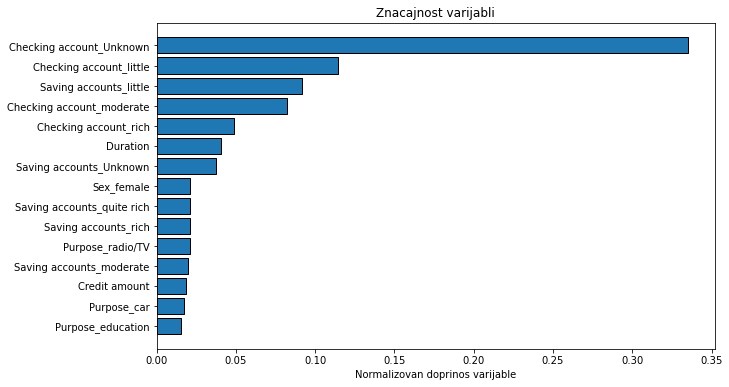

In [178]:
feature_importances_sorted = plot_feature_importances(feature_importances)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


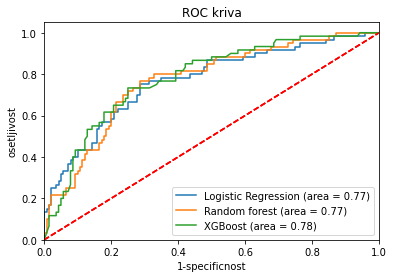

In [179]:
logit_roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
rf_roc_auc = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, random_forest.predict_proba(X_test)[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr_rf, tpr_rf, label='Random forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-specificnost')
plt.ylabel('osetljivost')
plt.title('ROC kriva')
plt.legend(loc="lower right")
plt.show()


## Interpretabilnost

In [37]:
explainer = shap.TreeExplainer(xgb_model,X_sm,model_output='probability')
shap_values = explainer.shap_values(X_sm)

In [38]:
xgb_model.predict_proba(np.array(X_sm.iloc[1,:]).reshape((1,-1)))

array([[0.51952493, 0.4804751 ]], dtype=float32)

In [39]:
shap.initjs()

In [40]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sm.iloc[0,:])

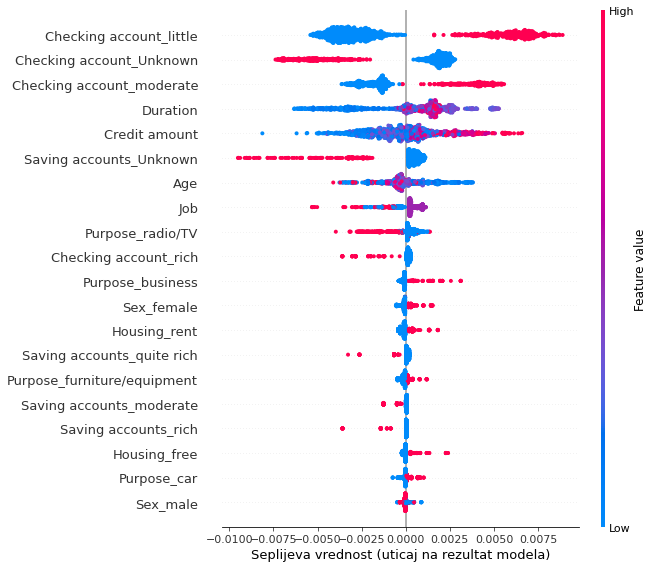

In [41]:
shap.summary_plot(shap_values, X_sm, show=False)
plt.xlabel("Seplijeva vrednost (uticaj na rezultat modela)")
plt.show()